## Learning from Isochrones: A machine learning approach to estimating stellar properties

### Part 1 - Testing the initial capabilities of regression for an isochrone trained network, assuming a tanh activation function

##### Luco Buise (s1055446)

---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as ip
import random as ran

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [2]:
# create training data

isochrones = ["FeH05", "FeH0", "FeH-05", "FeH-10", "FeH-15", "FeH-20", "FeH-25"]

isochrone_values = [0.5, 0, -0.5, -1, -1.5, -2, -2.5]

Y = np.array([])
X = np.array([])

for i, iso in enumerate(isochrones):

    loga, mag_B, mag_V = np.loadtxt('isochrones/small_data/isoc_' + iso + '.cmd', usecols=(1, 10, 11), unpack=True)
    loga = np.around(loga, decimals=2)
      
    # find the highest and lowest age in this isochrone
    min_age = min(loga)
    max_age = max(loga)
    steps = ((max_age - min_age) / 0.1) + 1
    
    # create the ages
    ages = np.linspace(min_age, max_age, int(steps))
    ages = np.around(ages, decimals=2)
        
    # set the y-values, first the age, then the metallicity
    y = np.array([(age, isochrone_values[i]) for age in ages])
    
    if len(Y) == 0:
        Y = y
    else:
        Y = np.append(Y, y, axis = 0)
    
    for age in ages:
        w = np.where(age == loga)
              
        r = sorted(ran.sample(range(0, len(mag_B[w])), 100))
            
        bv = (mag_B[w] - mag_V[w])[r]
        v = mag_V[w][r]

        x = np.array([np.append(bv, v)])

        if len(X) == 0:
            X = x
        else:
            X = np.append(X, x, axis = 0)

X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).float()
print(X.shape, Y.shape)

(308, 200) (308, 2)


In [3]:
# load the regressed testing data from files (see the Creating_Test_Data.ipynb notebook for more information)

X_OC = np.load('openClusters/oc_xdata.npy')
Y_OC = np.load('openClusters/oc_ydata.npy')

X_GC = np.load('globClusters/gc_xdata.npy')
Y_GC = np.load('globClusters/gc_ydata.npy')

X_OC = torch.from_numpy(X_OC).float()
Y_OC = torch.from_numpy(Y_OC).float()

X_GC = torch.from_numpy(X_GC).float()
Y_GC = torch.from_numpy(Y_GC).float()

In [4]:
# transform the test data of X_OC and X_GC by adding their distance modulus to the V values

# transform distances in kpc to distance modulus
def kpc_to_mod(kpc):
    return 5 * np.log10(10 / (kpc * 1000))

oc_distances = np.loadtxt("openClusters/Ages_and_properties.txt", usecols = (3), unpack=True)
gc_distances = np.loadtxt("globClusters/Distances.txt", usecols = (1), unpack=True)

gc_distances = kpc_to_mod(gc_distances) * -1

for i, d in enumerate(oc_distances):
    X_OC[i][100:] = X_OC[i][100:] - d

for i, d in enumerate(gc_distances):
    X_GC[i][100:] = X_GC[i][100:] - d


In [5]:
# create function to track average mse of model

# calculate the average MSE-loss of a given model and data over n runs
def avg_mse(model, X, Y, n = 1000):
    tot_mse_age = 0
    tot_mse_z = 0
    
    for i in range(n):
        predicted = model(X).data
        tot_mse_age += ((Y[:,0] - predicted[:,0])**2).mean()
        tot_mse_z += ((Y[:,1] - predicted[:,1])**2).mean()
        
    return tot_mse_age / n, tot_mse_z / n

In [6]:
# create and test regression model

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1

nr_hidden = np.linspace(10,100, 10)

mse_age_train = np.array([])
mse_z_train = np.array([])

mse_age_oc = np.array([])
mse_z_oc = np.array([])

mse_age_gc = np.array([])
mse_z_gc = np.array([])

for i, n in enumerate(nr_hidden):

    # define model
    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=int(n)),
        nn.Tanh(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=int(n), out_features=2),
    )

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # start training
    for step in range(3000):
        pre = model(X_train)
        mse = mse_loss(pre, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
     
    # keep track of mse of training set, open clusters, and globular clusters
    mse_age, mse_z = avg_mse(model, X_train, y_train)
    mse_age_train = np.append(mse_age_train, mse_age)
    mse_z_train = np.append(mse_z_train, mse_z)
    
    mse_age, mse_z = avg_mse(model, X_OC, Y_OC)
    mse_age_oc = np.append(mse_age_oc, mse_age)
    mse_z_oc = np.append(mse_z_oc, mse_z)
    
    mse_age, mse_z = avg_mse(model, X_GC, Y_GC)
    mse_age_gc = np.append(mse_age_gc, mse_age)
    mse_z_gc = np.append(mse_z_gc, mse_z)
    
    print("Iteration {} of {} completed!".format(i + 1, len(nr_hidden)))

Iteration 1 of 10 completed!
Iteration 2 of 10 completed!
Iteration 3 of 10 completed!
Iteration 4 of 10 completed!
Iteration 5 of 10 completed!
Iteration 6 of 10 completed!
Iteration 7 of 10 completed!
Iteration 8 of 10 completed!
Iteration 9 of 10 completed!
Iteration 10 of 10 completed!


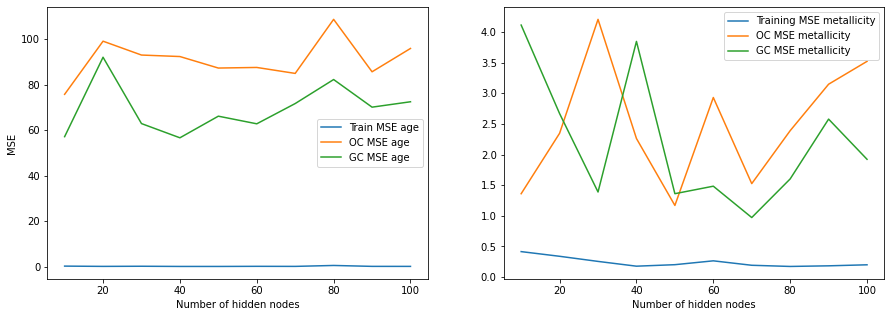

In [7]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

axs[0].plot(nr_hidden, mse_age_train, label = "Train MSE age")
axs[0].plot(nr_hidden, mse_age_oc, label = "OC MSE age")
axs[0].plot(nr_hidden, mse_age_gc, label = "GC MSE age")

axs[1].plot(nr_hidden, mse_z_train, label = "Training MSE metallicity")
axs[1].plot(nr_hidden, mse_z_oc, label = "OC MSE metallicity")
axs[1].plot(nr_hidden, mse_z_gc, label = "GC MSE metallicity")

axs[0].set_xlabel('Number of hidden nodes')
axs[1].set_xlabel('Number of hidden nodes')
axs[0].set_ylabel('MSE')

axs[0].legend()
axs[1].legend()
plt.savefig("Graphs/regr_tanh_mse.png")
plt.show()